In [1]:
!python /home/diego/proyectos/vae_AD/scripts/ablation_canales.py \
  --ablation_script_path /home/diego/proyectos/vae_AD/scripts/run_vae_clf_ad_ablation.py \
  --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz \
  --metadata_path /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv \
  --output_root ./ablation_full_run_fast \
  --metric auc \
  --outer_folds 3


[INFO] Discovered 7 channels from tensor key 'global_tensor_data'.

========== Channel Ablation ==========
Ablation script: /home/diego/proyectos/vae_AD/scripts/run_vae_clf_ad_ablation.py
Candidate channels (7): [0:Pearson_OMST_GCE_Signed_Weighted, 1:Pearson_Full_FisherZ_Signed, 2:MI_KNN_Symmetric, 3:dFC_AbsDiffMean, 4:dFC_StdDev, 5:DistanceCorr, 6:Granger_F_lag1]
Optimise metric:  auc
Min improvement:  0.001
Output root:      /home/diego/proyectos/vae_AD/notebooks/ablation_full_run_fast
[INVARIANT] Classifier: logreg (no HP tuning, no SMOTE)
[PARITY]    --vae_final_activation tanh  --metadata_features Age Sex


========== PHASE 1: Single-channel evaluation ==========

[RUN] /home/diego/anaconda3/envs/vae_ad/bin/python /home/diego/proyectos/vae_AD/scripts/run_vae_clf_ad_ablation.py --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_d

Usando: /home/diego/proyectos/vae_AD/notebooks/ablation_full_run_fast/summary_ablation.csv
Mejor paso (max mean): step=1, n=2, 0.7794 ± 0.0358 (SE)
Óptimo parsimonioso (1‑SE): step=0, n=1, mean=0.7555


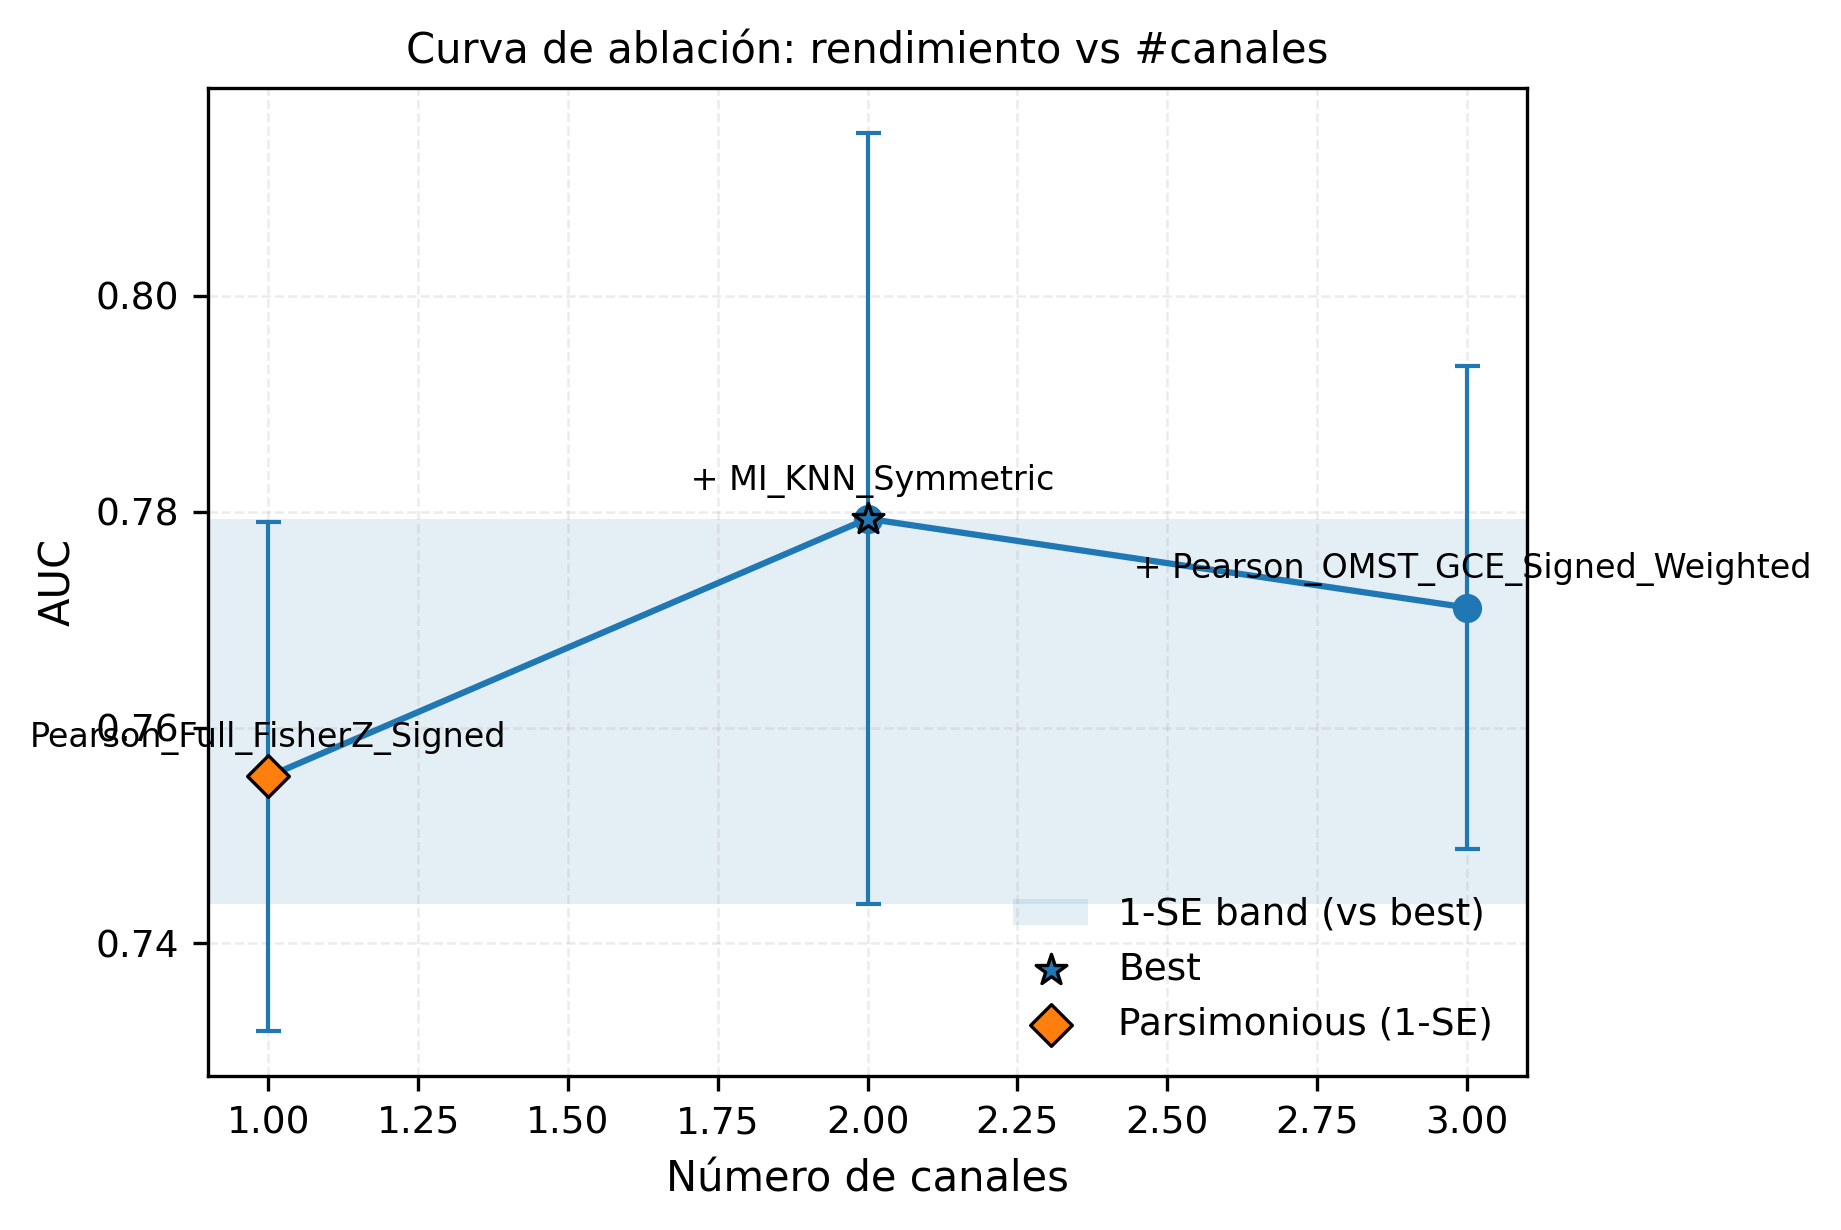

Guardado: Figures/fig_ablation_curve.png | Figures/fig_ablation_curve.pdf


In [2]:
# %% [markdown]
# # Curva de ablación (greedy forward selection)
# Este gráfico muestra la evolución del rendimiento (AUC) al añadir canales, 
# con barras de error (error estándar) y marcando el mejor punto y el óptimo parsimonioso (regla 1‑SE).

# %%
import os
import re
import math
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# CONFIGURACIÓN (ajusta las rutas a tu caso)
# ------------------------------------------------------------
SUMMARY_CSV = Path("/home/diego/proyectos/vae_AD/notebooks/ablation_full_run_fast/summary_ablation.csv")
FIGS_DIR    = Path("Figures")                # carpeta donde se guardarán las figuras
PAPER_DPI   = 300
N_FOLDS_DEFAULT = 3                           # nº de folds externos usado en tu ejecución

# Diccionario de nombres bonitos para canales (solo se usa como fallback)
DEFAULT_CHANNEL_NAMES = {
    0: 'Pearson_OMST_GCE_Signed_Weighted',
    1: 'Pearson_Full_FisherZ_Signed',
    2: 'MI_KNN_Symmetric',
    3: 'dFC_AbsDiffMean',
    4: 'dFC_StdDev',
    5: 'DistanceCorr',
    6: 'Granger_F_lag1',
}

# Estilo de las figuras
plt.rcParams.update({
    "figure.figsize": (6.0, 4.0),
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": PAPER_DPI,
})

FIGS_DIR.mkdir(parents=True, exist_ok=True)
print("Usando:", SUMMARY_CSV.resolve())

# ------------------------------------------------------------
# Cargar y procesar el resumen de ablación
# ------------------------------------------------------------
df = pd.read_csv(SUMMARY_CSV)

# Normalizar tipos
df["step"] = pd.to_numeric(df["step"], errors="coerce").astype("Int64")
df["metric_mean"] = pd.to_numeric(df["metric_mean"], errors="coerce")
df["metric_std"]  = pd.to_numeric(df["metric_std"],  errors="coerce")

# Convertir columna "channels_indices" (ej: "1 2 5") a lista de enteros
def parse_idx_list(s):
    if isinstance(s, str):
        s = s.strip()
        if not s:
            return []
        return [int(x) for x in s.split()]
    return []

df["channels_idx_list"] = df["channels_indices"].apply(parse_idx_list)
df["n_channels"] = df["channels_idx_list"].apply(len)

# Parsear nombres legibles desde "channels_pretty" (ej: "[1:NameA, 2:NameB]")
def parse_pretty_names(s):
    if not isinstance(s, str):
        return []
    s = s.strip().strip("[]")
    if not s:
        return []
    names = []
    for part in s.split(","):
        part = part.strip()
        if ":" in part:
            idx, name = part.split(":", 1)
            names.append(name.strip())
        else:
            names.append(part)
    return names

df["channels_names"] = df["channels_pretty"].apply(parse_pretty_names)

# Orden natural por paso (0 = mejor single)
df = df.sort_values(["step", "n_channels"]).reset_index(drop=True)

# ------------------------------------------------------------
# Inferir número de folds (para calcular error estándar)
# ------------------------------------------------------------
def infer_n_folds(metrics_csv_path: str) -> int:
    try:
        mdf = pd.read_csv(metrics_csv_path)
    except Exception:
        return N_FOLDS_DEFAULT

    # Buscar columna con información de fold
    fold_cols = [c for c in mdf.columns if re.search(r"fold|outer", c, re.I)]
    for col in fold_cols:
        try:
            n = pd.Series(mdf[col]).nunique()
            if 1 <= n <= 20:
                return int(n)
        except Exception:
            pass

    # Si no, contar filas del clasificador actual
    try:
        if "actual_classifier_type" in mdf.columns:
            clf = df.loc[0, "classifier"] if "classifier" in df.columns else None
            sub = mdf if clf is None else mdf[mdf["actual_classifier_type"] == clf]
            if 1 < len(sub) <= 20:
                return int(len(sub))
    except Exception:
        pass

    return N_FOLDS_DEFAULT

df["n_folds_inferred"] = df["metrics_csv"].apply(infer_n_folds)
df["std_err"] = df["metric_std"] / np.sqrt(df["n_folds_inferred"].clip(lower=1))

# ------------------------------------------------------------
# Etiquetas incrementales (qué canal se añadió en cada paso)
# ------------------------------------------------------------
def incremental_label(row, prev_row):
    if prev_row is None:
        # Paso 0: nombres del conjunto inicial
        if row["channels_names"]:
            return " + ".join(row["channels_names"])
        return " + ".join(DEFAULT_CHANNEL_NAMES.get(i, f"Ch{i}") for i in row["channels_idx_list"])

    prev_set = set(prev_row["channels_idx_list"])
    curr_set = set(row["channels_idx_list"])
    added = list(curr_set - prev_set)
    if not added:
        return ""

    # Mapear índices a nombres
    if row["channels_names"] and len(row["channels_names"]) == len(row["channels_idx_list"]):
        idx_to_name = dict(zip(row["channels_idx_list"], row["channels_names"]))
    else:
        idx_to_name = {i: DEFAULT_CHANNEL_NAMES.get(i, f"Ch{i}") for i in row["channels_idx_list"]}

    return " + " + " + ".join(idx_to_name.get(i, f"Ch{i}") for i in added)

labels_inc = []
prev = None
for _, r in df.iterrows():
    labels_inc.append(incremental_label(r, prev))
    prev = r
df["label_incremental"] = labels_inc

# ------------------------------------------------------------
# Identificar mejor punto y punto parsimonioso (regla 1‑SE)
# ------------------------------------------------------------
best_idx = int(df["metric_mean"].idxmax())
best_row = df.loc[best_idx]
best_mean = float(best_row["metric_mean"])
best_se   = float(best_row["std_err"])

threshold = best_mean - best_se
candidates = df[df["metric_mean"] >= threshold]
parsimonious_idx = int(candidates.sort_values(["n_channels", "metric_mean"], ascending=[True, False]).index[0])
parsimonious_row = df.loc[parsimonious_idx]

print(f"Mejor paso (max mean): step={int(best_row['step'])}, n={int(best_row['n_channels'])}, "
      f"{best_mean:.4f} ± {best_se:.4f} (SE)")
print(f"Óptimo parsimonioso (1‑SE): step={int(parsimonious_row['step'])}, "
      f"n={int(parsimonious_row['n_channels'])}, mean={parsimonious_row['metric_mean']:.4f}")

# ------------------------------------------------------------
# Dibujar la curva
# ------------------------------------------------------------
x = df["n_channels"].values
y = df["metric_mean"].values
se = df["std_err"].values

fig, ax = plt.subplots(figsize=(6.2, 4.2))

# Línea con puntos
ax.plot(x, y, marker="o", linewidth=1.5, color="C0")
ax.errorbar(x, y, yerr=se, fmt="none", capsize=3, linewidth=1, color="C0")

# Banda 1‑SE (desde el mejor)
ax.axhspan(threshold, best_mean, alpha=0.12, lw=0, label="1‑SE band (vs best)")

# Destacar mejor y parsimonioso
ax.scatter([best_row["n_channels"]], [best_mean], s=60, zorder=3,
           marker="*", label="Best", edgecolor="k", linewidth=0.8)
ax.scatter([parsimonious_row["n_channels"]], [parsimonious_row["metric_mean"]], s=50, zorder=3,
           marker="D", label="Parsimonious (1‑SE)", edgecolor="k", linewidth=0.8)

# Etiquetas incrementales
for xi, yi, lbl in zip(x, y, df["label_incremental"].values):
    if lbl:
        ax.annotate(lbl, (xi, yi), textcoords="offset points",
                    xytext=(0, 7), ha="center", fontsize=8, rotation=0)

ax.set_xlabel("Número de canales")
ax.set_ylabel(df.loc[0, "metric"].upper() if "metric" in df.columns else "AUC")
ax.set_title("Curva de ablación: rendimiento vs #canales")
ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)
ax.legend(loc="lower right", frameon=False)

plt.tight_layout()

# Guardar
out_png = FIGS_DIR / "fig_ablation_curve.png"
out_pdf = FIGS_DIR / "fig_ablation_curve.pdf"
plt.savefig(out_png, dpi=PAPER_DPI)
plt.savefig(out_pdf)
plt.show()

print("Guardado:", out_png, "|", out_pdf)